In [1]:
# Import libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import http.client

# Data exploration and preprocessing
import spacy
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

# Build and train models
import keras_tuner as kt
from collections import Counter
from transformers import BertTokenizer, TFBertForSequenceClassification
import warnings

c:\Users\Esther\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Scraping of job listings from Adzuna API

In [ ]:
# Adzuna API credentials and base URL for UK jobs
APP_ID = "ee5e2937"
APP_KEY = "b85d8687343a341fcf5bf76131a48ad2"
BASE_URL = "https://api.adzuna.com/v1/api/jobs/gb/search/{}"

all_jobs = []

# Loop through first 10 pages
for page in range(1, 11):  # pages 1 to 11
    url = BASE_URL.format(page)
    params = {
        "app_id": APP_ID,
        "app_key": APP_KEY,
        "results_per_page": 50,
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for job in data.get("results", []):
            all_jobs.append({
            "id": job.get("id"),
            "title": job.get("title"),
            "company": job.get("company", {}).get("display_name"),
            "location": job.get("location", {}).get("display_name"),
            "category": job.get("category", {}).get("label"),
            "created": job.get("created"),
            "url": job.get("redirect_url"),
            "description": job.get("description"),
            "salary_min": job.get("salary_min"),
            "salary_max": job.get("salary_max"),
            "contract_type": job.get("contract_type"),
            "contract_time": job.get("contract_time"),
            })
    else:
        print(f"Failed on page {page}: {response.status_code}")
        print(response.text)

# Save all jobs to CSV
df = pd.DataFrame(all_jobs)
df.to_csv("adzuna_jobs_gb.csv", index=False)
print("Saved jobs to adzuna_jobs_gb.csv")

Saved jobs to adzuna_jobs_gb.csv


## 2. Loading of the jobs and resume dataset

In [2]:
jobs_gb = pd.read_csv('adzuna_jobs_gb.csv')
jobs_gb.tail()

,id,title,company,location,category,created,url,description,salary_min,salary_max,contract_type,contract_time
495,5168803027,Commercial Property Associate - Leicester / No...,"Chadwick Nott - East and West Midlands, NHC & ...","Leicester, Leicestershire",Legal Jobs,2025-04-29T16:23:11Z,https://www.adzuna.co.uk/jobs/details/51688030...,Commercial Property Associate - Leicester / No...,55000.00,70000.00,NaN,NaN
496,5191868195,Social Worker,Charles Hunter Associates,"Bath, Bath & N E Somerset",Social work Jobs,2025-05-10T08:46:42Z,https://www.adzuna.co.uk/jobs/details/51918681...,We are looking for a Social Worker to join our...,0.00,79040.00,NaN,full_time
497,5048185212,Senior Design Manager (Water/Wastewater Engine...,Stantec,"Cardiff, Cardiff County",Engineering Jobs,2025-02-13T11:07:22Z,https://www.adzuna.co.uk/jobs/details/50481852...,Shape the future of Water Infrastructure with ...,50036.26,50036.26,NaN,NaN
498,4986013035,Trainee Data Analyst (Career Accelerator with ...,Nuyew Tech Academy,"Hyde Park, Leeds",IT Jobs,2024-12-22T02:50:22Z,https://www.adzuna.co.uk/jobs/details/49860130...,Are you passionate about uncovering insights f...,35000.00,35000.00,permanent,NaN
499,5185140382,Personal Advisor – Leaving Care Team – Birmingham,Pertemps Professional Recruitment,"Birmingham, West Midlands",Social work Jobs,2025-05-07T13:27:29Z,https://www.adzuna.co.uk/jobs/details/51851403...,Personal Advisor – Leaving Care Team – Birming...,41620.00,41620.00,contract,full_time


In [3]:
# Load the resumes data
resumes = pd.read_csv("Resume.csv")
resumes.tail()

,ID,Resume_str,Resume_html,Category
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...","<div class=""fontsize fontface vmargins hmargin...",AVIATION
2481,31605080,GEEK SQUAD AGENT Professional...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2483,37473139,STOREKEEPER II Professional Sum...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION


## 3. Data Preprocessing

In [4]:
jobs_gb['category'].value_counts()

category
Teaching Jobs                       127
Engineering Jobs                     50
IT Jobs                              39
Healthcare & Nursing Jobs            37
Social work Jobs                     30
Legal Jobs                           29
Sales Jobs                           23
Customer Services Jobs               23
Hospitality & Catering Jobs          22
Logistics & Warehouse Jobs           18
Trade & Construction Jobs            15
Accounting & Finance Jobs            13
Retail Jobs                          10
Graduate Jobs                        10
Manufacturing Jobs                   10
PR, Advertising & Marketing Jobs      9
Domestic help & Cleaning Jobs         8
HR & Recruitment Jobs                 6
Admin Jobs                            6
Part time Jobs                        4
Consultancy Jobs                      3
Maintenance Jobs                      3
Property Jobs                         2
Other/General Jobs                    2
Creative & Design Jobs         

In [5]:
# Check the number of unique categories in the resumes dataset
resumes['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

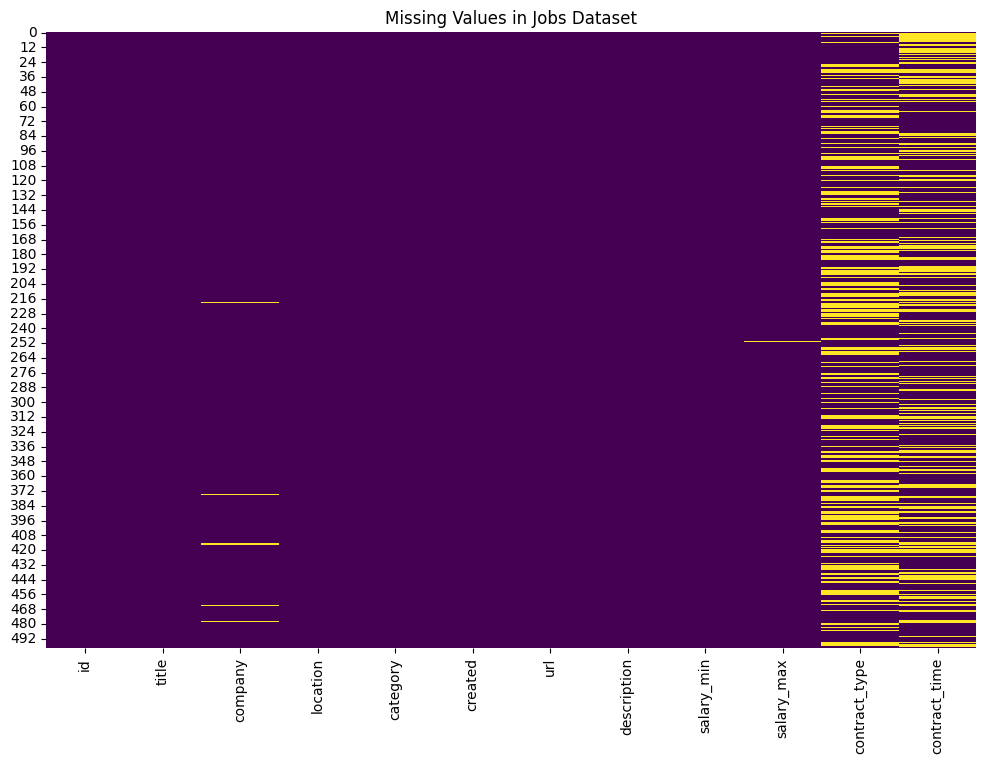

In [6]:
# use heatmap to visualize the missing values in the jobs dataset
plt.figure(figsize=(12, 8))
sns.heatmap(jobs_gb.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Jobs Dataset")
plt.show()

In [7]:
#resumes.isnull().sum()  no missing values in the resumes dataset
# check for missing values in the different columns
jobs_gb.isnull().sum()

id                 0
title              0
company            5
location           0
category           0
created            0
url                0
description        0
salary_min         0
salary_max         1
contract_type    183
contract_time    169
dtype: int64

In [8]:
# Standardize column names
resumes.columns = resumes.columns.str.strip().str.lower()
jobs_gb.columns = jobs_gb.columns.str.strip().str.lower()

In [9]:
# Fill the missing values in contract type, contract time and company with 'unknown' and salary max with 0
jobs_gb.fillna({'salary_max':0}, inplace=True)
jobs_gb.fillna({'contract_type':'unknown'}, inplace=True)
jobs_gb.fillna({'contract_time':'unknown'}, inplace=True)
jobs_gb.fillna({'commpany':'unknown'}, inplace=True)

In [10]:
# Drop url column in the jobs dataset and resume_html in resumes dataset
jobs_gb.drop(columns='url', inplace=True)
resumes.drop(columns='resume_html', inplace=True)

In [11]:
# chcek the data types of the columns
jobs_gb.dtypes

id                 int64
title             object
company           object
location          object
category          object
created           object
description       object
salary_min       float64
salary_max       float64
contract_type     object
contract_time     object
dtype: object

In [12]:
jobs_gb[['salary_min', 'salary_max']].describe()

,salary_min,salary_max
count,500.000000,500.000000
mean,36133.845660,44346.551660
std,22708.096319,26237.799317
min,0.000000,0.000000
25%,26436.000000,29120.000000
50%,31650.000000,40000.000000
75%,42050.000000,51179.000000
max,336000.000000,378000.000000


In [13]:
# Create a new column on the average salary
jobs_gb['salary_avg'] = (jobs_gb['salary_min'] + jobs_gb['salary_max']) / 2

In [14]:
# Standardize column names
resumes.columns = resumes.columns.str.strip().str.lower()
jobs_gb.columns = jobs_gb.columns.str.strip().str.lower()

In [16]:
# Remove extra whitespace and bullets
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # collapse whitespace
    text = text.replace('\u2022', '')  # remove bullets
    return text.strip()

# Clean the 'description' column
jobs_gb['description'] = jobs_gb['description'].apply(clean_text)
resumes['resume_str'] = resumes['resume_str'].apply(clean_text)

In [17]:
# convert to csv
jobs_gb.to_csv('jobs_gb_cleaned.csv', index=False)
resumes.to_csv('resumes.csv', index=False)